In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
base_paths = [
    r'C:\Users\pidik\Downloads',
    r'C:\Users\pidik\Downloads'
]

fall_dataset_path, nonfall_dataset_path = None, None
for base in base_paths:
    fall_path = os.path.join(base, 'datasets')
    nonfall_path = os.path.join(base, 'nfDatasets')
    if os.path.isdir(fall_path):
        fall_dataset_path = fall_path
    if os.path.isdir(nonfall_path):
        nonfall_dataset_path = nonfall_path

if fall_dataset_path is None or nonfall_dataset_path is None:
    raise FileNotFoundError("Fall or non-fall dataset folders not found in expected locations.")

print(f"✅ Fall dataset path: {fall_dataset_path}")
print(f"✅ Non-fall dataset path: {nonfall_dataset_path}")


✅ Fall dataset path: C:\Users\pidik\Downloads\datasets
✅ Non-fall dataset path: C:\Users\pidik\Downloads\nfDatasets


In [3]:
image_size = (64, 64)
tau = 15  # Temporal duration for MHI

def compute_mhi(frames, tau=15):
    h, w = frames[0].shape
    mhi = np.zeros((h, w), dtype=np.float32)
    for t, frame in enumerate(frames):
        if t == 0:
            prev = frame
            continue
        diff = cv2.absdiff(frame, prev)
        _, motion_mask = cv2.threshold(diff, 30, 1, cv2.THRESH_BINARY)
        mhi[motion_mask == 1] = tau
        mhi[motion_mask == 0] -= 1
        mhi[mhi < 0] = 0
        prev = frame
    return (mhi / tau * 255).astype(np.uint8)

def preprocess_frame(frame):
    frame = cv2.resize(frame, image_size)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    eq = cv2.equalizeHist(gray)
    return eq


In [ ]:
def load_mhi_from_folder(folder_path, label):
    X, y = [], []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            frames = []
            for img_file in sorted(os.listdir(class_path)):
                img_path = os.path.join(class_path, img_file)
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img = cv2.imread(img_path)
                    if img is not None:
                        frames.append(preprocess_frame(img))
            if len(frames) >= tau:
                mhi = compute_mhi(frames[-tau:], tau)
                X.append(mhi.flatten())
                y.append(label)
    return X, y


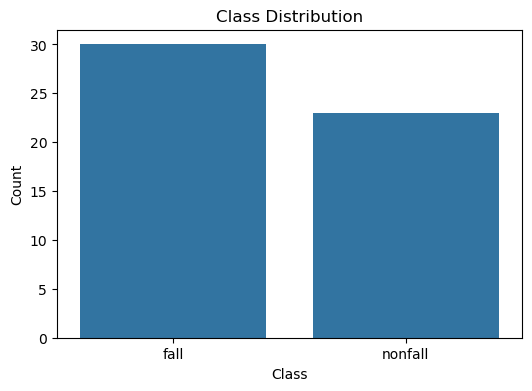

In [5]:
fall_X, fall_y = load_mhi_from_folder(fall_dataset_path, 'fall')
nonfall_X, nonfall_y = load_mhi_from_folder(nonfall_dataset_path, 'nonfall')

X = np.array(fall_X + nonfall_X)
y = np.array(fall_y + nonfall_y)

plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [7]:
models = {
    "SVM": SVC(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "k-NN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced')
}



📊 Model: SVM
✅ Accuracy: 0.7273
✅ F1 Score: 0.7133
Predicted classes: [0 1]
              precision    recall  f1-score   support

        fall       1.00      0.50      0.67         6
     nonfall       0.62      1.00      0.77         5

    accuracy                           0.73        11
   macro avg       0.81      0.75      0.72        11
weighted avg       0.83      0.73      0.71        11



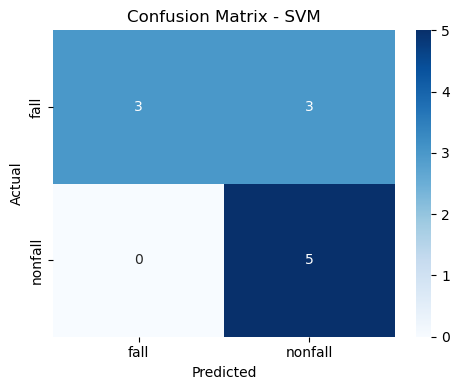


📊 Model: Decision Tree
✅ Accuracy: 0.4545
✅ F1 Score: 0.4455
Predicted classes: [0 1]
              precision    recall  f1-score   support

        fall       0.50      0.33      0.40         6
     nonfall       0.43      0.60      0.50         5

    accuracy                           0.45        11
   macro avg       0.46      0.47      0.45        11
weighted avg       0.47      0.45      0.45        11



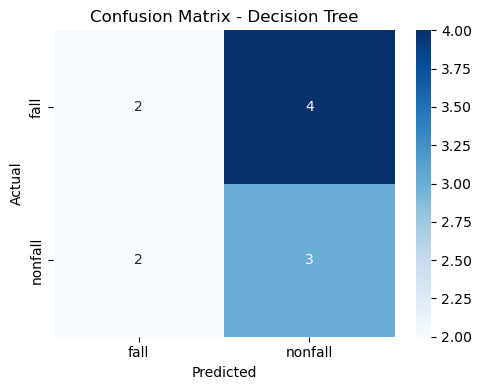


📊 Model: Random Forest
✅ Accuracy: 0.6364
✅ F1 Score: 0.6303
Predicted classes: [0 1]
              precision    recall  f1-score   support

        fall       0.75      0.50      0.60         6
     nonfall       0.57      0.80      0.67         5

    accuracy                           0.64        11
   macro avg       0.66      0.65      0.63        11
weighted avg       0.67      0.64      0.63        11



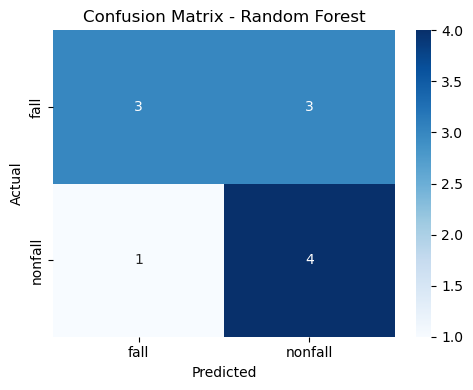


📊 Model: k-NN
✅ Accuracy: 0.5455
✅ F1 Score: 0.3850
Predicted classes: [0]
              precision    recall  f1-score   support

        fall       0.55      1.00      0.71         6
     nonfall       0.00      0.00      0.00         5

    accuracy                           0.55        11
   macro avg       0.27      0.50      0.35        11
weighted avg       0.30      0.55      0.39        11



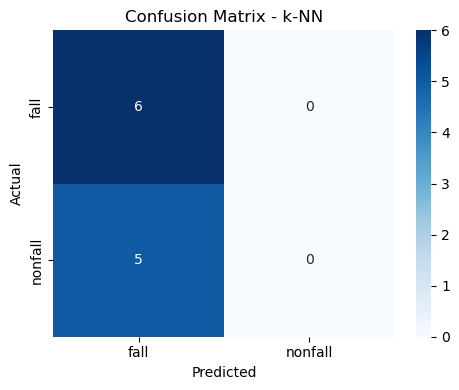


📊 Model: Logistic Regression
✅ Accuracy: 0.7273
✅ F1 Score: 0.7133
Predicted classes: [0 1]
              precision    recall  f1-score   support

        fall       1.00      0.50      0.67         6
     nonfall       0.62      1.00      0.77         5

    accuracy                           0.73        11
   macro avg       0.81      0.75      0.72        11
weighted avg       0.83      0.73      0.71        11



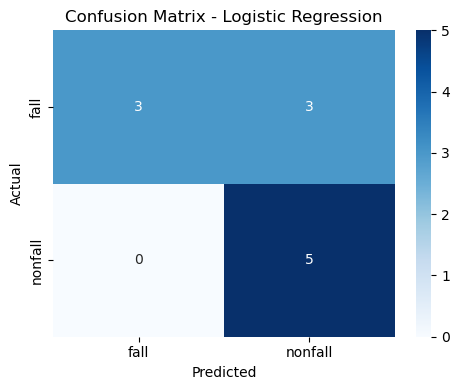

In [8]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "Accuracy": acc,
        "F1 Score": f1,
        "Report": report,
        "ConfusionMatrix": cm
    }

    print(f"\n📊 Model: {name}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"Predicted classes: {np.unique(y_pred)}")
    print(report)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


In [9]:
print("\n📌 Final Summary:")
print(f"{'Model':<20} {'Accuracy':<10} {'F1 Score'}")
for model, metrics in results.items():
    print(f"{model:<20} {metrics['Accuracy']:<10.4f} {metrics['F1 Score']:.4f}")



📌 Final Summary:
Model                Accuracy   F1 Score
SVM                  0.7273     0.7133
Decision Tree        0.4545     0.4455
Random Forest        0.6364     0.6303
k-NN                 0.5455     0.3850
Logistic Regression  0.7273     0.7133


✅ Fall dataset path: C:\Users\pidik\Downloads\datasets
✅ Non-fall dataset path: C:\Users\pidik\Downloads\nfDatasets

📁 Processing fall dataset from: C:\Users\pidik\Downloads\datasets


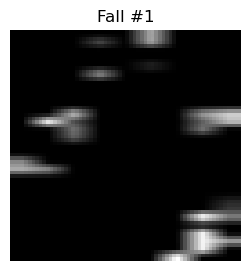

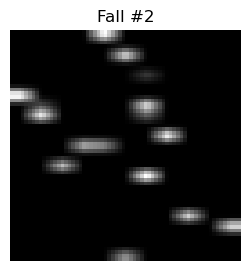

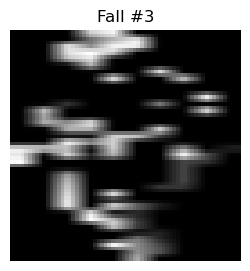

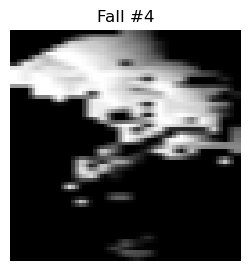

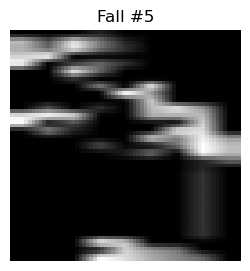

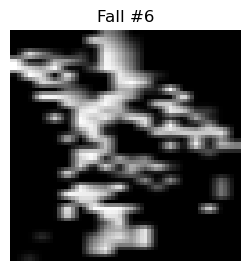

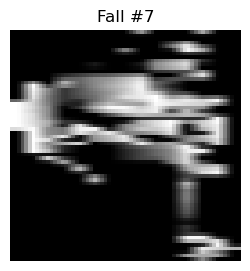

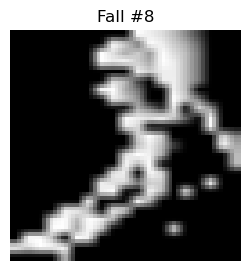

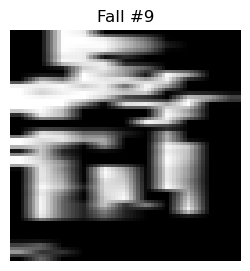

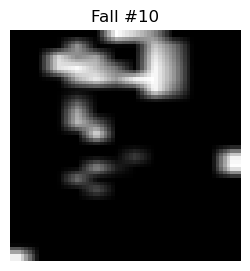

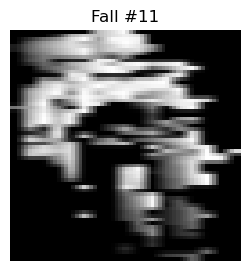

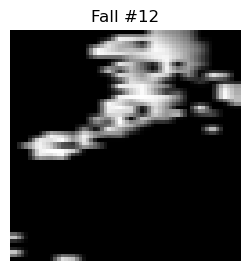

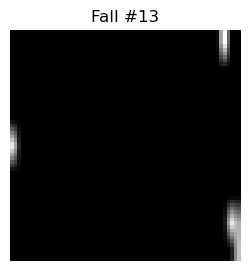

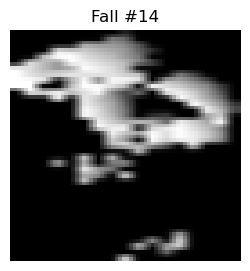

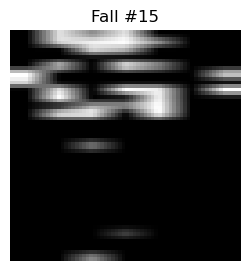

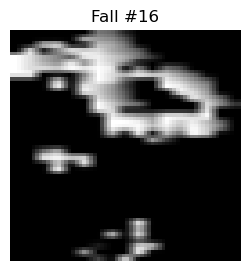

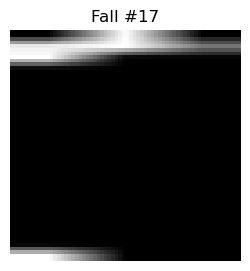

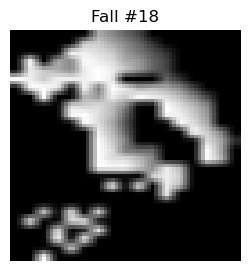

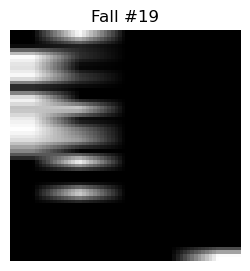

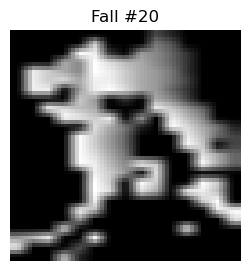

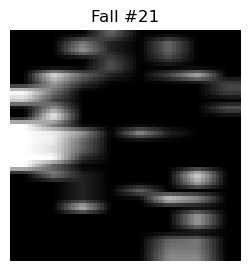

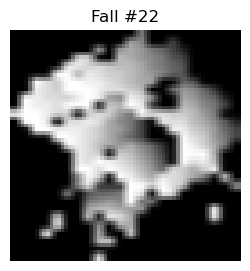

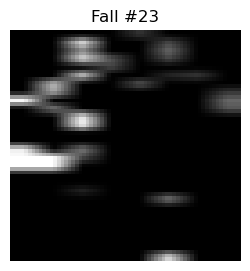

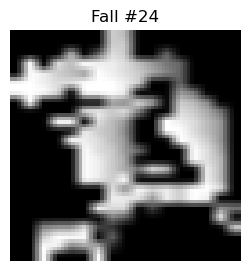

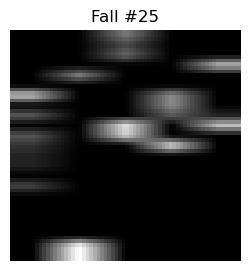

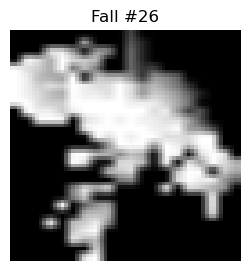

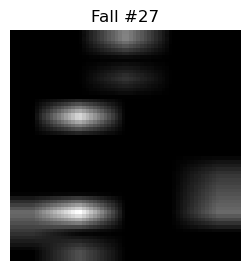

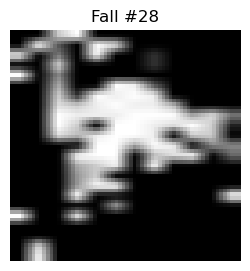

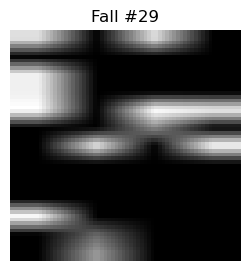

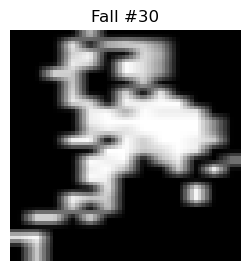


📁 Processing non-fall dataset from: C:\Users\pidik\Downloads\nfDatasets


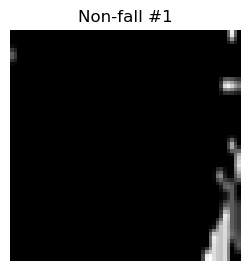

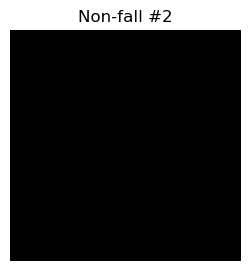

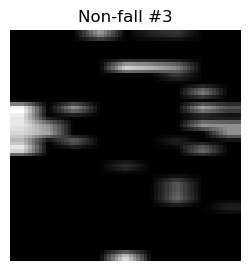

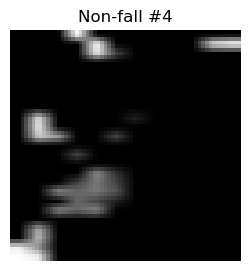

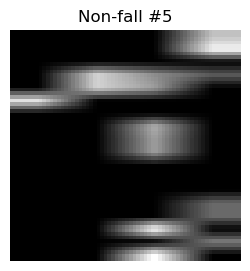

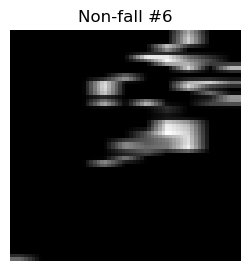

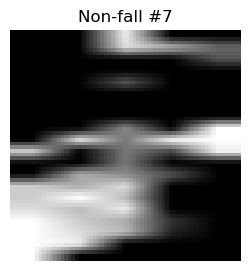

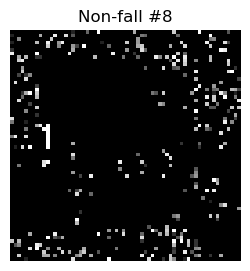

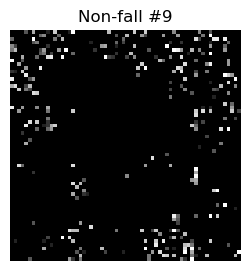

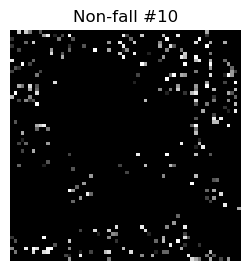

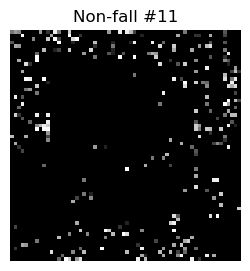

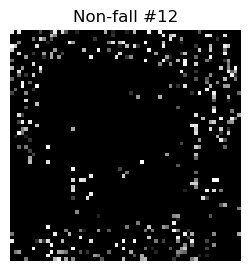

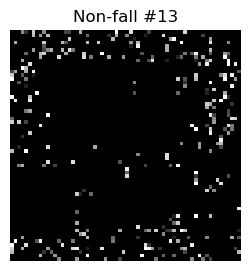

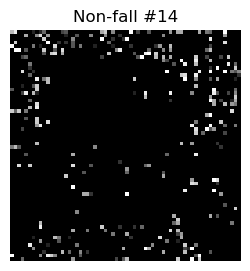

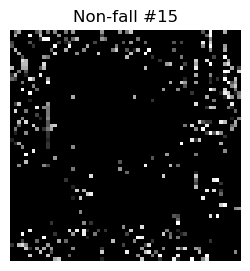

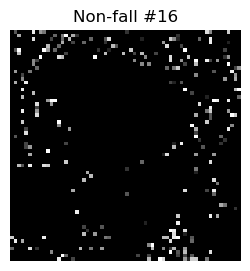

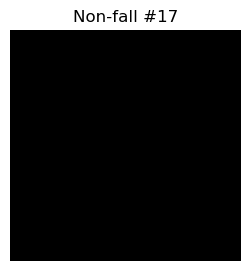

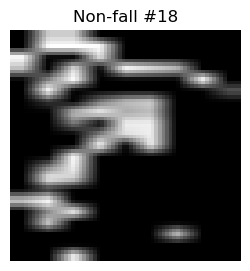

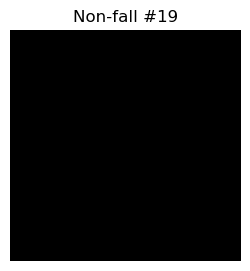

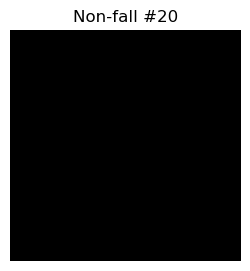

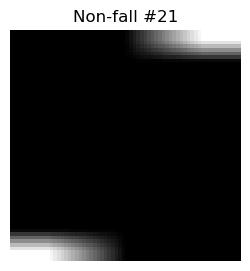

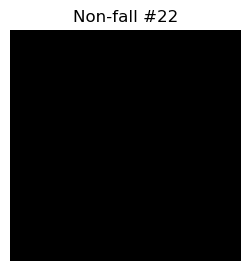

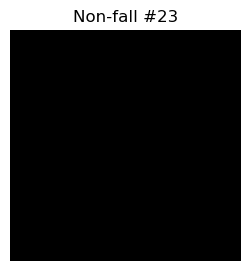

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Global resize size
TARGET_SIZE = (64, 64)

# Preprocess single frame with resizing and histogram equalization
def preprocess_frame(frame, size=TARGET_SIZE):
    resized = cv2.resize(frame, size)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    return equalized

# Compute MHI for list of frames
def compute_mhi(frames, tau=15):
    h, w = frames[0].shape
    mhi = np.zeros((h, w), dtype=np.float32)

    for t, frame in enumerate(frames):
        if t == 0:
            prev = frame
            continue
        diff = cv2.absdiff(frame, prev)
        _, motion_mask = cv2.threshold(diff, 30, 1, cv2.THRESH_BINARY)
        mhi[motion_mask == 1] = tau
        mhi[motion_mask == 0] -= 1
        mhi[mhi < 0] = 0
        prev = frame

    mhi_normalized = (mhi / tau * 255).astype(np.uint8)

    # Crop to the region of motion
    contours, _ = cv2.findContours(mhi_normalized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(np.vstack(contours))
        mhi_cropped = mhi_normalized[y:y+h, x:x+w]
        # Resize cropped area back to original size for uniformity
        mhi_cropped = cv2.resize(mhi_cropped, TARGET_SIZE)
    else:
        mhi_cropped = mhi_normalized

    return mhi_cropped, mhi_cropped.flatten()

# Load N preprocessed (resized + equalized) grayscale frames from a folder
def load_frame_sequence(folder_path, frame_count=15, target_size=TARGET_SIZE):
    frame_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])[:frame_count]
    frames = []

    for file in frame_files:
        path = os.path.join(folder_path, file)
        frame = cv2.imread(path)
        if frame is not None:
            processed = preprocess_frame(frame, size=target_size)
            frames.append(processed)

    if len(frames) < frame_count:
        raise ValueError(f"Not enough frames in {folder_path} to generate MHI")

    return frames

# Dataset detection
base_paths = [
    r'C:\Users\pidik\Downloads',
    r'C:\Users\pidik\Downloads'
]

fall_dataset_path, nonfall_dataset_path = None, None
for base in base_paths:
    fall_path = os.path.join(base, 'datasets')
    nonfall_path = os.path.join(base, 'nfDatasets')
    if os.path.isdir(fall_path):
        fall_dataset_path = fall_path
    if os.path.isdir(nonfall_path):
        nonfall_dataset_path = nonfall_path

if fall_dataset_path is None or nonfall_dataset_path is None:
    raise FileNotFoundError("Fall or non-fall dataset folders not found in expected locations.")

print(f"✅ Fall dataset path: {fall_dataset_path}")
print(f"✅ Non-fall dataset path: {nonfall_dataset_path}")

# Display MHI for a few videos in a dataset inline
def display_mhi_images(dataset_path, label, max_videos=5, frame_count=15):
    print(f"\n📁 Processing {label} dataset from: {dataset_path}")
    subfolders = [os.path.join(dataset_path, d) for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    for idx, folder in enumerate(subfolders[:max_videos]):
        try:
            frames = load_frame_sequence(folder, frame_count)
            mhi_img, _ = compute_mhi(frames)
            plt.figure(figsize=(3, 3))
            plt.title(f"{label.capitalize()} #{idx+1}")
            plt.imshow(mhi_img, cmap='gray')
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"⚠️ Skipping {folder} due to error: {e}")

# Display MHI samples from both fall and non-fall datasets
display_mhi_images(fall_dataset_path, "fall", max_videos=30)
display_mhi_images(nonfall_dataset_path, "non-fall", max_videos=23)



📁 Processing Fall and Non-Fall datasets for comparison:


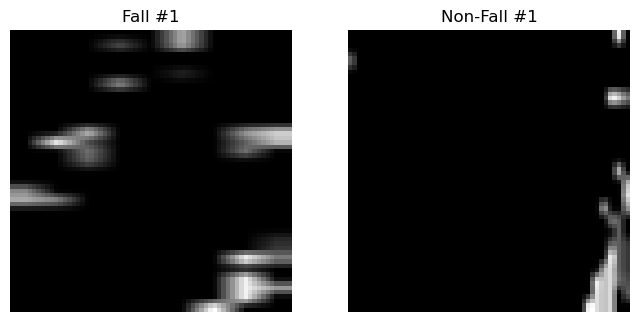

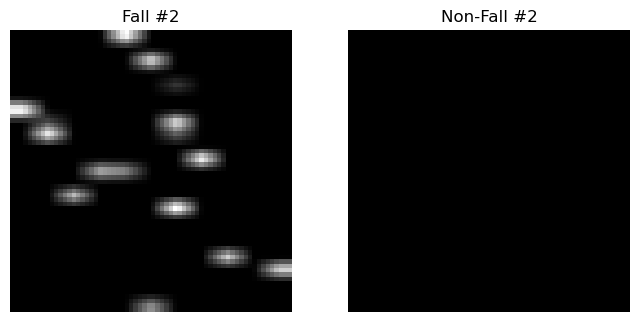

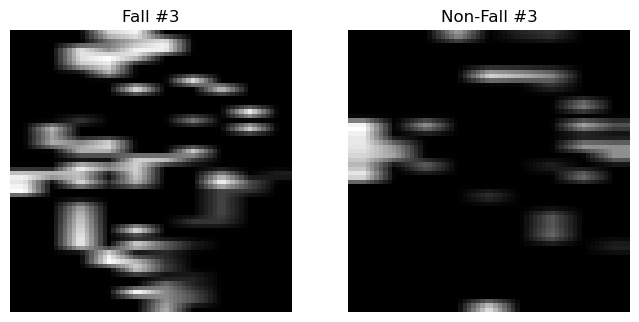

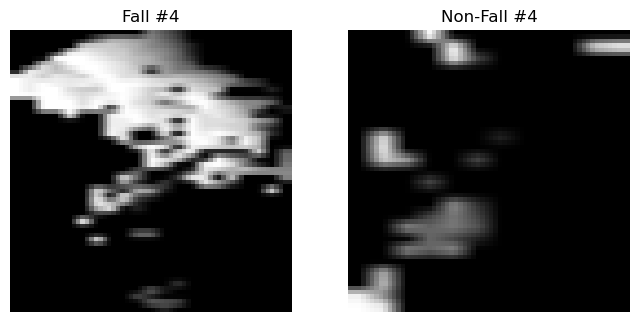

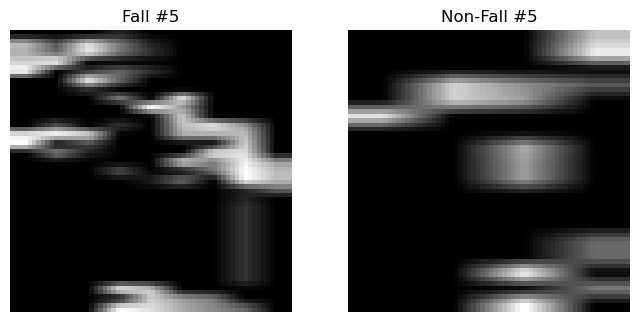

In [8]:
def display_mhi_comparison(fall_dataset_path, nonfall_dataset_path, max_videos=5, frame_count=15):
    print(f"\n📁 Processing Fall and Non-Fall datasets for comparison:")

    fall_subfolders = [os.path.join(fall_dataset_path, d) for d in os.listdir(fall_dataset_path) if os.path.isdir(os.path.join(fall_dataset_path, d))]
    nonfall_subfolders = [os.path.join(nonfall_dataset_path, d) for d in os.listdir(nonfall_dataset_path) if os.path.isdir(os.path.join(nonfall_dataset_path, d))]

    # Take min of both sets to avoid index errors (if there are fewer non-fall videos)
    max_videos = min(len(fall_subfolders), len(nonfall_subfolders), max_videos)

    for idx in range(max_videos):
        try:
            # Load frames and compute MHI for Fall and Non-Fall videos
            fall_frames = load_frame_sequence(fall_subfolders[idx], frame_count)
            nonfall_frames = load_frame_sequence(nonfall_subfolders[idx], frame_count)

            fall_mhi, _ = compute_mhi(fall_frames)
            nonfall_mhi, _ = compute_mhi(nonfall_frames)

            # Plot side-by-side comparison
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.title(f"Fall #{idx+1}")
            plt.imshow(fall_mhi, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title(f"Non-Fall #{idx+1}")
            plt.imshow(nonfall_mhi, cmap='gray')
            plt.axis('off')

            plt.show()

        except Exception as e:
            print(f"⚠️ Skipping pair #{idx+1} due to error: {e}")

# Display MHI comparison between Fall and Non-Fall samples
display_mhi_comparison(fall_dataset_path, nonfall_dataset_path, max_videos=5)


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
base_paths = [
    r'C:\Users\pidik\Downloads',
    r'C:\Users\pidik\Downloads'
]

fall_dataset_path, nonfall_dataset_path = None, None
for base in base_paths:
    fall_path = os.path.join(base, 'datasets')
    nonfall_path = os.path.join(base, 'nfDatasets')
    if os.path.isdir(fall_path):
        fall_dataset_path = fall_path
    if os.path.isdir(nonfall_path):
        nonfall_dataset_path = nonfall_path

if fall_dataset_path is None or nonfall_dataset_path is None:
    raise FileNotFoundError("Fall or non-fall dataset folders not found in expected locations.")

print(f"✅ Fall dataset path: {fall_dataset_path}")
print(f"✅ Non-fall dataset path: {nonfall_dataset_path}")


✅ Fall dataset path: C:\Users\pidik\Downloads\datasets
✅ Non-fall dataset path: C:\Users\pidik\Downloads\nfDatasets


In [3]:
TARGET_SIZE = (64, 64)

def preprocess_frame(frame, size=TARGET_SIZE):
    resized = cv2.resize(frame, size)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    return equalized


In [4]:
def compute_mhi(frames, tau=15):
    h, w = frames[0].shape
    mhi = np.zeros((h, w), dtype=np.float32)

    for t, frame in enumerate(frames):
        if t == 0:
            prev = frame
            continue
        diff = cv2.absdiff(frame, prev)
        _, motion_mask = cv2.threshold(diff, 30, 1, cv2.THRESH_BINARY)
        mhi[motion_mask == 1] = tau
        mhi[motion_mask == 0] -= 1
        mhi[mhi < 0] = 0
        prev = frame

    mhi_normalized = (mhi / tau * 255).astype(np.uint8)

    # Crop to motion area
    contours, _ = cv2.findContours(mhi_normalized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(np.vstack(contours))
        mhi_cropped = mhi_normalized[y:y+h, x:x+w]
        mhi_cropped = cv2.resize(mhi_cropped, TARGET_SIZE)
    else:
        mhi_cropped = mhi_normalized

    return mhi_cropped, mhi_cropped.flatten()


In [5]:
def load_frame_sequence(folder_path, frame_count=15, target_size=TARGET_SIZE):
    frame_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])[:frame_count]
    frames = []

    for file in frame_files:
        path = os.path.join(folder_path, file)
        frame = cv2.imread(path)
        if frame is not None:
            processed = preprocess_frame(frame, size=target_size)
            frames.append(processed)

    if len(frames) < frame_count:
        raise ValueError(f"Not enough frames in {folder_path} to generate MHI")

    return frames


In [6]:
def load_mhi_from_folder(folder_path, label):
    X, y = [], []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            try:
                frames = load_frame_sequence(class_path)
                mhi, flattened = compute_mhi(frames)
                X.append(flattened)
                y.append(label)
            except Exception as e:
                print(f"⚠️ Skipping {class_folder} due to error: {e}")
    return X, y


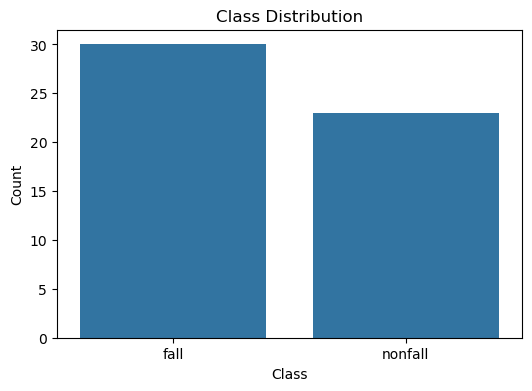

In [8]:
fall_X, fall_y = load_mhi_from_folder(fall_dataset_path, 'fall')
nonfall_X, nonfall_y = load_mhi_from_folder(nonfall_dataset_path, 'nonfall')

X = np.array(fall_X + nonfall_X)
y = np.array(fall_y + nonfall_y)

plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [9]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



📊 Model: SVM
✅ Accuracy: 0.8182
✅ F1 Score: 0.8182
Predicted classes: [0 1]
              precision    recall  f1-score   support

        fall       0.83      0.83      0.83         6
     nonfall       0.80      0.80      0.80         5

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11



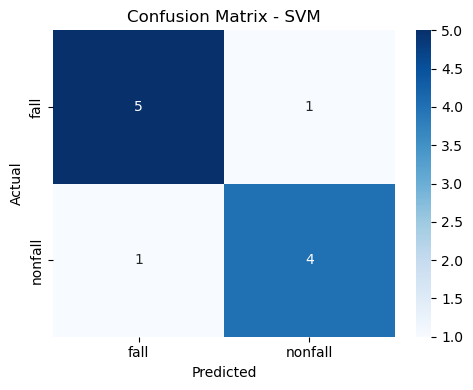


📊 Model: Decision Tree
✅ Accuracy: 0.7273
✅ F1 Score: 0.7226
Predicted classes: [0 1]
              precision    recall  f1-score   support

        fall       0.71      0.83      0.77         6
     nonfall       0.75      0.60      0.67         5

    accuracy                           0.73        11
   macro avg       0.73      0.72      0.72        11
weighted avg       0.73      0.73      0.72        11



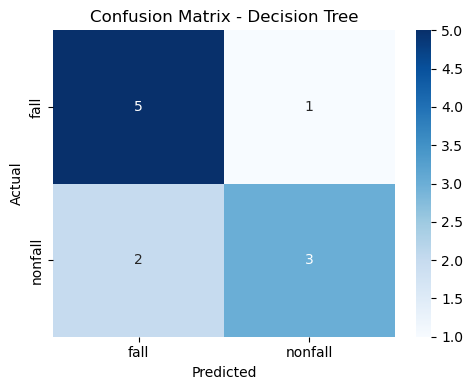


📊 Model: Random Forest
✅ Accuracy: 0.7273
✅ F1 Score: 0.7226
Predicted classes: [0 1]
              precision    recall  f1-score   support

        fall       0.71      0.83      0.77         6
     nonfall       0.75      0.60      0.67         5

    accuracy                           0.73        11
   macro avg       0.73      0.72      0.72        11
weighted avg       0.73      0.73      0.72        11



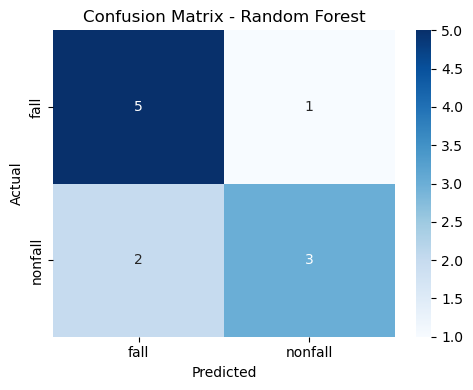


📊 Model: k-NN
✅ Accuracy: 0.7273
✅ F1 Score: 0.7273
Predicted classes: [0 1]
              precision    recall  f1-score   support

        fall       0.80      0.67      0.73         6
     nonfall       0.67      0.80      0.73         5

    accuracy                           0.73        11
   macro avg       0.73      0.73      0.73        11
weighted avg       0.74      0.73      0.73        11



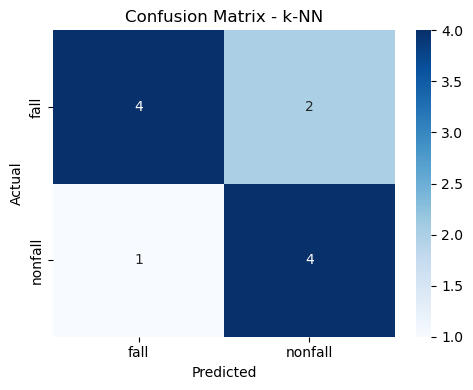


📊 Model: Logistic Regression
✅ Accuracy: 0.7273
✅ F1 Score: 0.7226
Predicted classes: [0 1]
              precision    recall  f1-score   support

        fall       0.71      0.83      0.77         6
     nonfall       0.75      0.60      0.67         5

    accuracy                           0.73        11
   macro avg       0.73      0.72      0.72        11
weighted avg       0.73      0.73      0.72        11



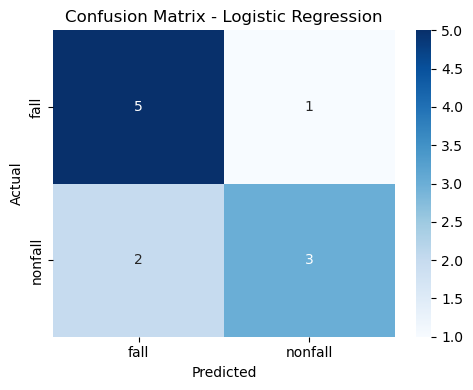

In [10]:
models = {
    "SVM": SVC(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "k-NN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced')
}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "Accuracy": acc,
        "F1 Score": f1,
        "Report": report,
        "ConfusionMatrix": cm
    }

    print(f"\n📊 Model: {name}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"Predicted classes: {np.unique(y_pred)}")
    print(report)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


In [14]:
print("\n📌 Final Summary:")
print(f"{'Model':<20} {'Accuracy':<10} {'F1 Score'}")
for model, metrics in results.items():
    print(f"{model:<20} {metrics['Accuracy']:<10.4f} {metrics['F1 Score']:.4f}")



📌 Final Summary:
Model                Accuracy   F1 Score
SVM                  0.8182     0.8182
Decision Tree        0.7273     0.7226
Random Forest        0.7273     0.7226
k-NN                 0.7273     0.7273
Logistic Regression  0.7273     0.7226


In [18]:
def display_mhi_images(dataset_path, label, max_videos=5, frame_count=15):
    print(f"\n📁 Processing {label} dataset from: {dataset_path}")
    subfolders = [os.path.join(dataset_path, d) for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    for idx, folder in enumerate(subfolders[:max_videos]):
        try:
            frames = load_frame_sequence(folder, frame_count)
            mhi_img, _ = compute_mhi(frames)
            plt.figure(figsize=(3, 3))
            plt.title(f"{label.capitalize()} #{idx+1}")
            plt.imshow(mhi_img, cmap='gray')
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"⚠️ Skipping {folder} due to error: {e}")



📁 Processing fall dataset from: C:\Users\pidik\Downloads\datasets


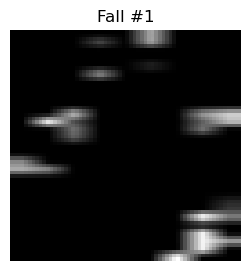

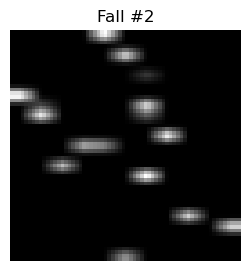

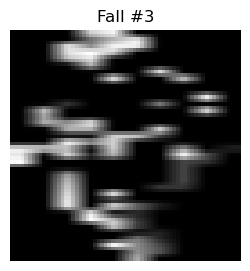

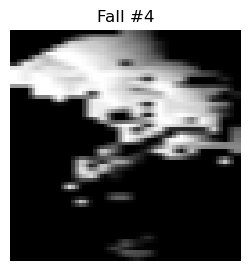

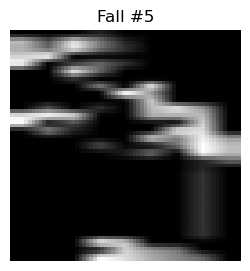

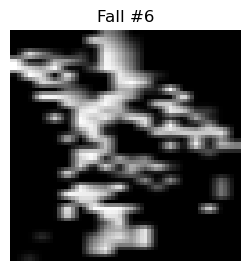

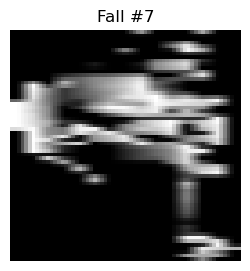

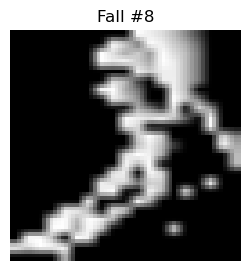

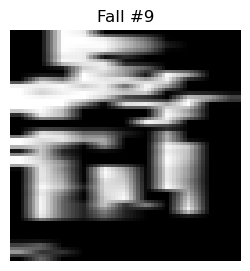

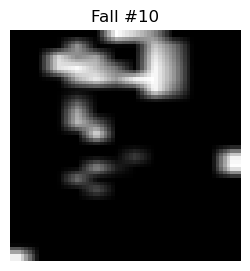

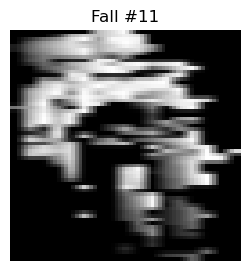

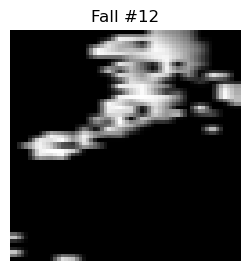

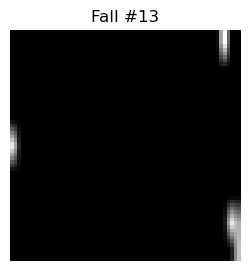

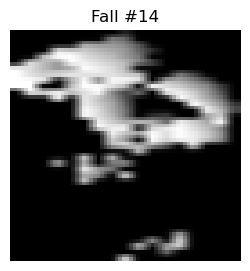

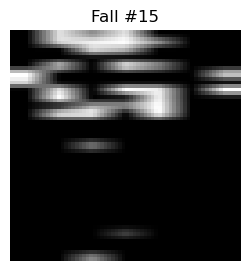

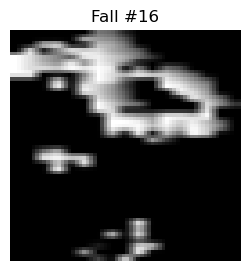

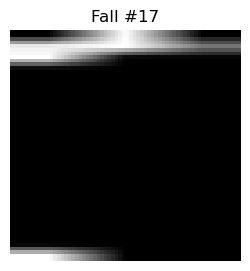

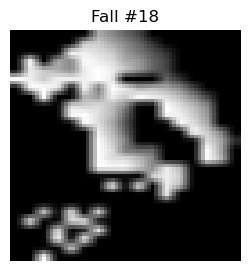

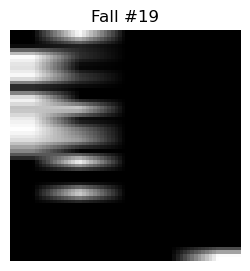

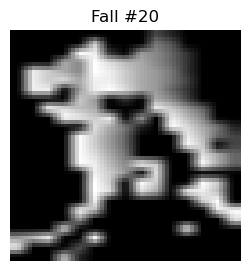

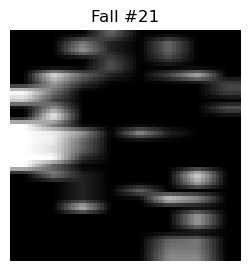

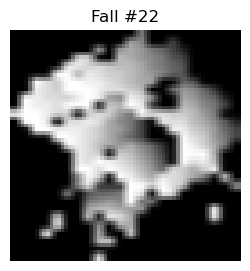

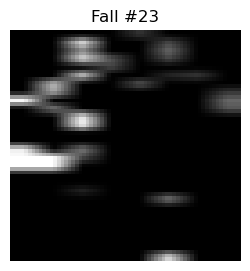

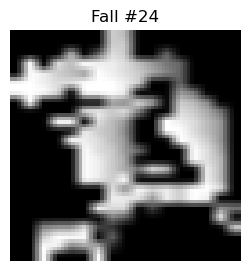

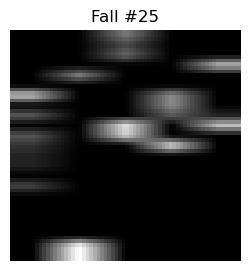

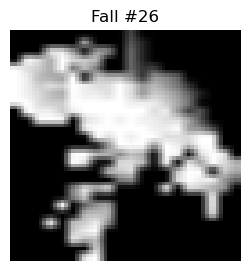

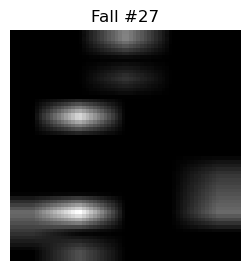

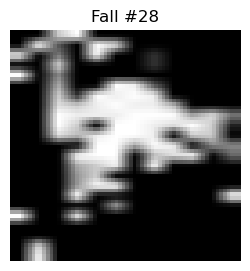

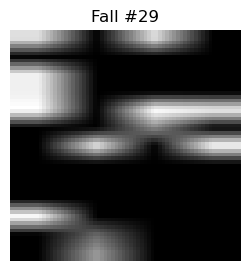

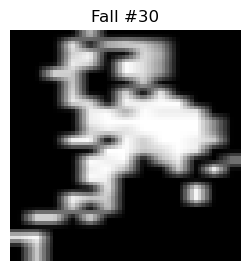


📁 Processing non-fall dataset from: C:\Users\pidik\Downloads\nfDatasets


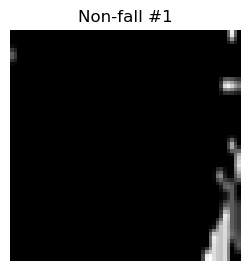

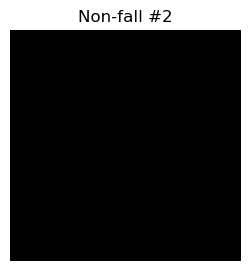

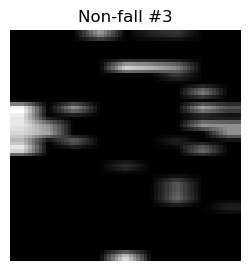

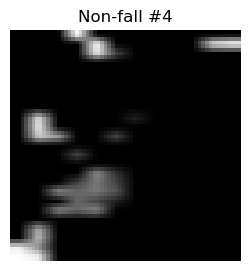

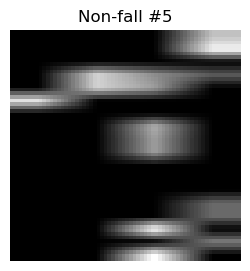

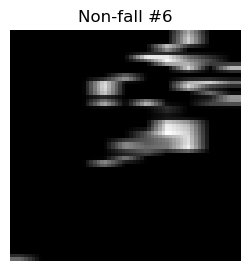

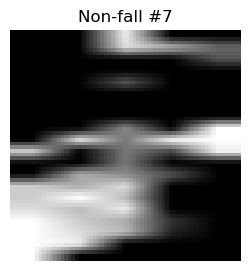

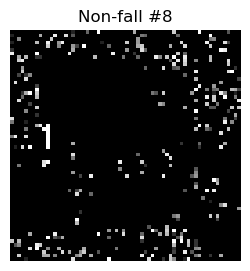

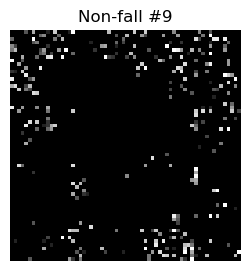

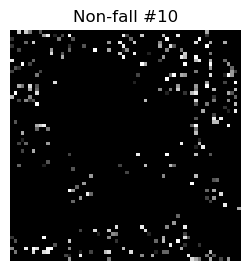

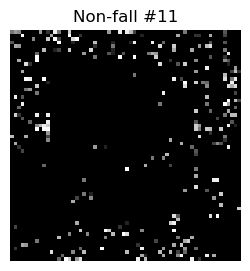

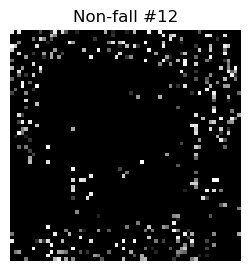

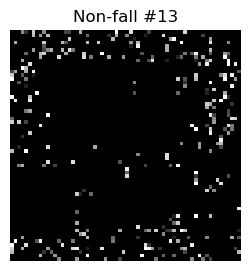

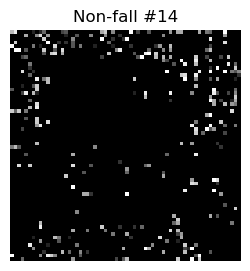

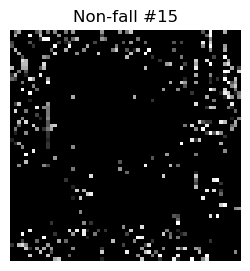

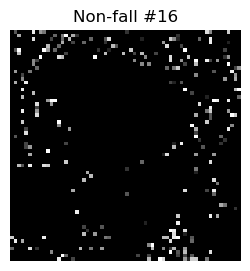

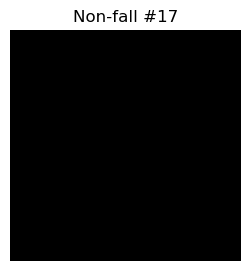

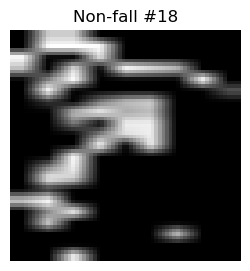

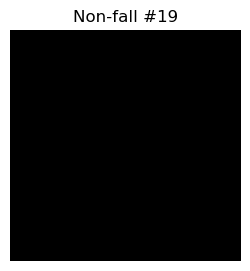

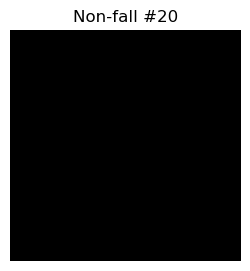

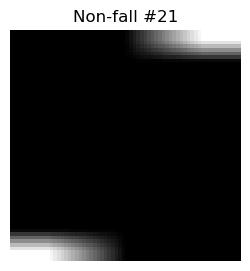

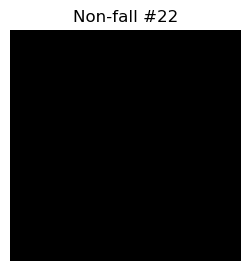

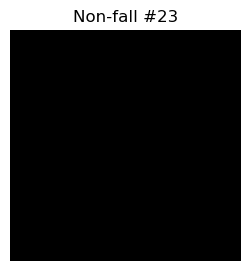

In [17]:
# Call for visualization (optional)
display_mhi_images(fall_dataset_path, "fall", max_videos=30)
display_mhi_images(nonfall_dataset_path, "non-fall", max_videos=23)


In [19]:
def display_mhi_comparison(fall_path, nonfall_path, max_videos=5):
    fall_folders = [os.path.join(fall_path, d) for d in os.listdir(fall_path) if os.path.isdir(os.path.join(fall_path, d))][:max_videos]
    nonfall_folders = [os.path.join(nonfall_path, d) for d in os.listdir(nonfall_path) if os.path.isdir(os.path.join(nonfall_path, d))][:max_videos]

    for i in range(min(len(fall_folders), len(nonfall_folders))):
        try:
            fall_frames = load_frame_sequence(fall_folders[i])
            nonfall_frames = load_frame_sequence(nonfall_folders[i])

            fall_mhi, _ = compute_mhi(fall_frames)
            nonfall_mhi, _ = compute_mhi(nonfall_frames)

            plt.figure(figsize=(6, 3))
            plt.suptitle(f"Comparison #{i+1}", fontsize=14)

            plt.subplot(1, 2, 1)
            plt.title("Fall")
            plt.imshow(fall_mhi, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Non-Fall")
            plt.imshow(nonfall_mhi, cmap='gray')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"⚠️ Skipping comparison #{i+1} due to error: {e}")


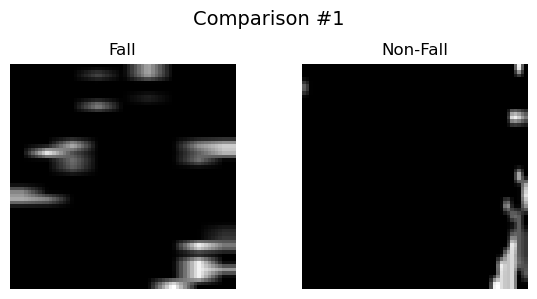

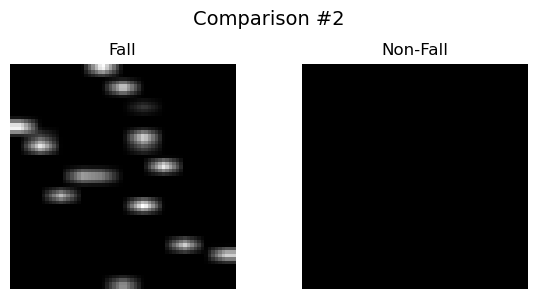

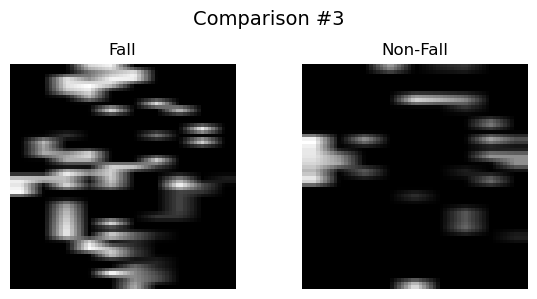

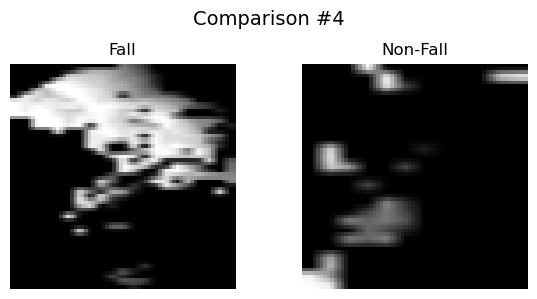

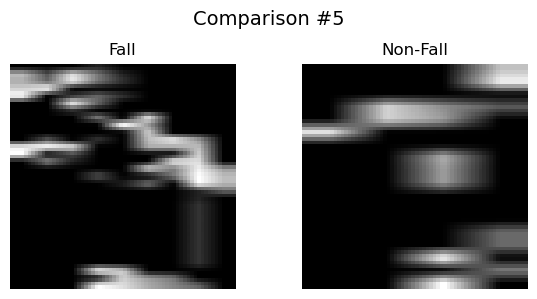

In [20]:
# Call to display MHI comparisons
display_mhi_comparison(fall_dataset_path, nonfall_dataset_path, max_videos=5)
